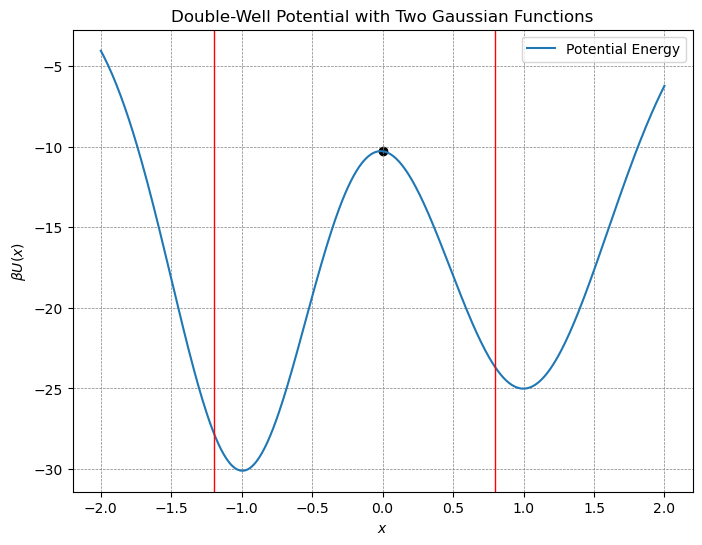

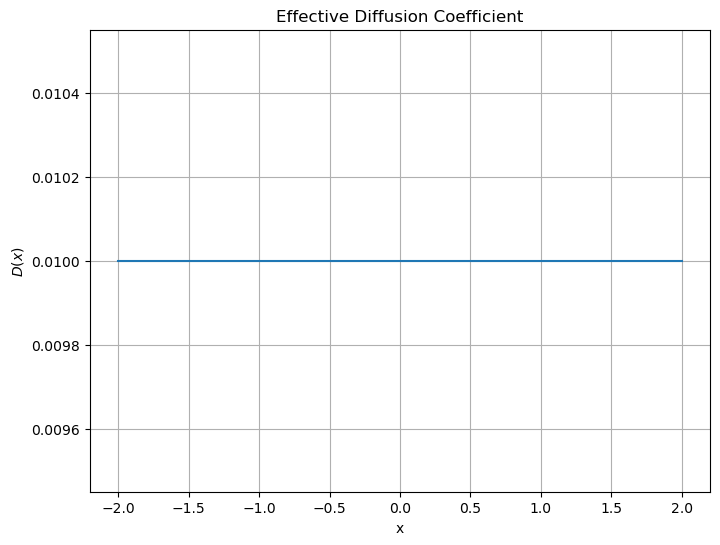

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Define the double-well potential using two Gaussian functions
# def beta_U(x, A1=3, mu1=-1, sigma1=0.5, A2=4, mu2=1, sigma2=0.6):
def beta_U(x, A1=30, mu1=-1, sigma1=0.5, A2=25, mu2=1, sigma2=0.6):
    V1 = A1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2))
    V2 = A2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
    return -(V1 + V2)
    # return V2

D0 = 0.01
def D(x):
    # return D0*x**(2/3)
    return D0*x**0
x = np.linspace(-2, 2, 400)

# Plot the potential
plt.figure(figsize=(8, 6))
plt.plot(x, beta_U(x), label='Potential Energy')
plt.title('Double-Well Potential with Two Gaussian Functions')
plt.xlabel('$x$')
plt.ylabel(r'$\beta U(x)$')
# plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0.8, color='red',linewidth=1)
plt.axvline(-1.2, color='red',linewidth=1)
plt.scatter(0, beta_U(0), color='black')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(x, D(x))
plt.xlabel('x')
plt.ylabel("$D(x)$")
plt.title('Effective Diffusion Coefficient')
plt.grid(True)
plt.show()

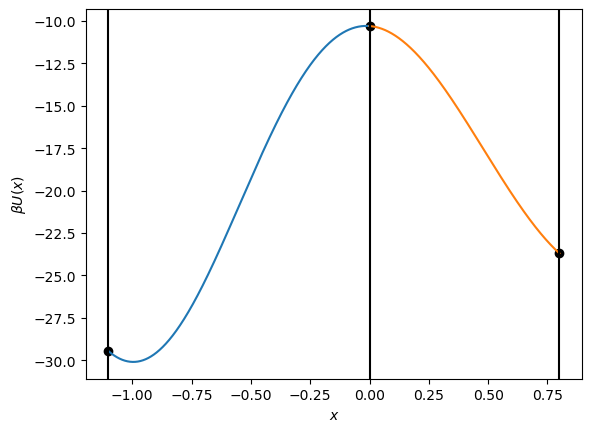

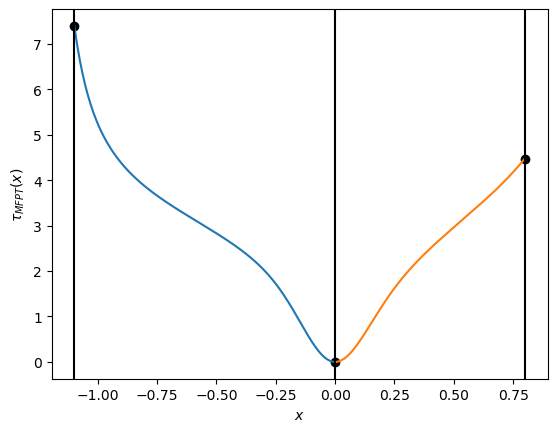

In [115]:
a = 0.0   # location of Injecting point
b1 = -1.1   # location of lower absorbing boundary
b2 = 0.8   # location of upper absorbing boundary
h = 0.001

N = int((b2-b1)/h+1)
x_arr = np.linspace(b1, b2, N)
re_inject_idx = np.where(np.round(x_arr, decimals=10) == a)[0][0]

N1 = int((a-b1)/h+1)
N2 = int((b2-a)/h+1)
x1_arr = np.linspace(b1, a, N1)
x2_arr = np.linspace(a, b2, N2)
# Plot the potential
plt.plot(x1_arr, beta_U(x1_arr), label='Potential Energy')
plt.plot(x2_arr, beta_U(x2_arr), label='Potential Energy')
plt.xlabel('$x$')
plt.ylabel(r'$\beta U(x)$')
plt.axvline(a, color='black')
plt.axvline(b1, color='black')
plt.axvline(b2, color='black')
plt.scatter(a, beta_U(a), color='black')
plt.scatter(b1, beta_U(b1), color='black')
plt.scatter(b2, beta_U(b2), color='black')
plt.show()

from transfer_matrix_recycle import TransferMatrix_AbInAb
from transfer_matrix_reptile import TransferMatrix_InReAb, TransferMatrix_AbReIn

ari1_trans = TransferMatrix_AbReIn(h, x1_arr, beta_U, 0)
ira2_trans = TransferMatrix_InReAb(h, x2_arr, beta_U, 0)

def get_steady_state(ria_trans):
    idx_fixed_vect = np.where(np.round(ria_trans.eig6_w.real, decimals=10) == 1)[0][0]
    steady_state = ria_trans.eig6_v[:,idx_fixed_vect].real/(h*np.sum(ria_trans.eig6_v[:,idx_fixed_vect].real))
    return steady_state

ari1_trans.steady_state = get_steady_state(ari1_trans)
ira2_trans.steady_state = get_steady_state(ira2_trans)


def mfpt_matrix(transMat_instance):
    ria_trans = transMat_instance
    ria_P = ria_trans.trans_mat.T
    idx_fixed_vect = np.where(np.round(ria_trans.eig6_w.real, decimals=10) == 1)[0][0]
    vec_pi = ria_trans.eig6_v[:,idx_fixed_vect].real/np.sum(ria_trans.eig6_v[:,idx_fixed_vect].real)
    N = vec_pi.size
    epsilon = np.ones(N)
    mat_I = np.eye(N)
    mat_E = np.ones((N, N))
    mat_Z = np.linalg.inv(mat_I-ria_P+np.outer(epsilon, vec_pi))
    vec_Zdg = np.diag(mat_Z)
    mat_Zdg = np.diag(vec_Zdg)
    mat_Mdg = np.diag(1/vec_pi)
    mat_M = (mat_I - mat_Z + mat_E @ mat_Zdg) @ mat_Mdg
    mat_Mbar = mat_M - mat_Mdg
    return mat_Mbar

m1_bar = mfpt_matrix(ari1_trans)
m2_bar = mfpt_matrix(ira2_trans)
delt_t = h**2/(2*D0)

plt.plot(x1_arr[1: ], delt_t*m1_bar[-1], label="ARI-MFPT")
plt.plot(x2_arr[:-1], delt_t*m2_bar[0], label="IRA-MFPT")
plt.xlabel('$x$')
plt.ylabel(r"$\tau_{MFPT} (x)$")
plt.axvline(a, color='black')
plt.axvline(b1, color='black')
plt.axvline(b2, color='black')
plt.scatter(a, delt_t*m1_bar[-1][-1], color='black')
plt.scatter(b1, delt_t*m1_bar[-1][0], color='black')
plt.scatter(b2, delt_t*m2_bar[0][-1], color='black')
plt.show()


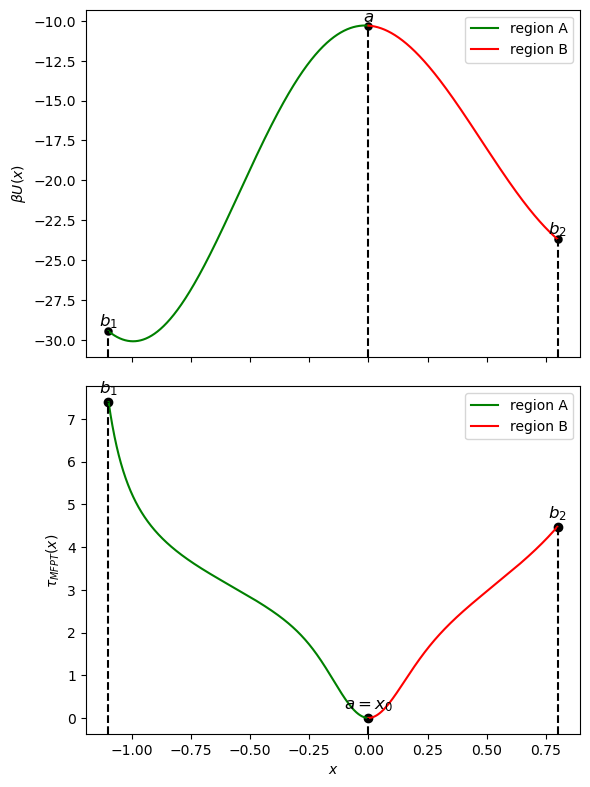

In [116]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

# Plot the first graph: Potential Energy
ax1.plot(x1_arr, beta_U(x1_arr), color='green', label='region A')
ax1.plot(x2_arr, beta_U(x2_arr), color='red', label='region B')

ymin, ymax = ax1.get_ylim()  # Get the y-axis limits of the first plot

# Normalize the points' y-values to determine the ymax value for the vertical lines
y_a = (beta_U(a) - ymin) / (ymax - ymin)
y_b1 = (beta_U(b1) - ymin) / (ymax - ymin)
y_b2 = (beta_U(b2) - ymin) / (ymax - ymin)

# Draw the vertical lines from ymin to the points
ax1.axvline(a, color='black', linestyle='--', ymax=y_a)
ax1.axvline(b1, color='black', linestyle='--', ymax=y_b1)
ax1.axvline(b2, color='black', linestyle='--', ymax=y_b2)
ax1.scatter([a, b1, b2], [beta_U(a), beta_U(b1), beta_U(b2)], color='black', linewidths=0.1)

# Label the points
ax1.text(a, beta_U(a)+0.04, r'$a$', verticalalignment='bottom', horizontalalignment='center', fontsize=12)
ax1.text(b1, beta_U(b1)+0.04, r'$b_1$', verticalalignment='bottom', horizontalalignment='center', fontsize=12)
ax1.text(b2, beta_U(b2)+0.04, r'$b_2$', verticalalignment='bottom', horizontalalignment='center', fontsize=12)

# Label the axes
ax1.set_ylabel(r'$\beta U(x)$')
# ax1.set_title('Double Gaussian Potential')

# Plot the second graph: MFPT
ax2.plot(x1_arr[1:], delt_t * m1_bar[-1], label="region A", color='green')
ax2.plot(x2_arr[:-1], delt_t * m2_bar[0], label="region B", color='red')

ymin2, ymax2 = ax2.get_ylim()

# Normalize the points' y-values for the second plot
y_a_mfpt = (delt_t * m1_bar[-1][-1] - ymin2) / (ymax2 - ymin2)
y_b1_mfpt = (delt_t * m1_bar[-1][0] - ymin2) / (ymax2 - ymin2)
y_b2_mfpt = (delt_t * m2_bar[0][-1] - ymin2) / (ymax2 - ymin2)

# Draw the vertical lines from ymin2 to the points in the second plot
ax2.axvline(a, color='black', linestyle='--', ymax=y_a_mfpt)
ax2.axvline(b1, color='black', linestyle='--', ymax=y_b1_mfpt)
ax2.axvline(b2, color='black', linestyle='--', ymax=y_b2_mfpt)

# Add scatter points for MFPT values
ax2.scatter([a, b1, b2], [delt_t * m1_bar[-1][-1], delt_t * m1_bar[-1][0], delt_t * m2_bar[0][-1]], color='black')

# Label the points
ax2.text(a, delt_t * m1_bar[-1][-1]+0.1, r'$a=x_0$', verticalalignment='bottom', horizontalalignment='center', fontsize=12)
ax2.text(b1, delt_t * m1_bar[-1][0]+0.1, r'$b_1$', verticalalignment='bottom', horizontalalignment='center', fontsize=12)
ax2.text(b2, delt_t * m2_bar[0][-1]+0.1, r'$b_2$', verticalalignment='bottom', horizontalalignment='center', fontsize=12)

# Label the axes
ax2.set_xlabel('$x$')
ax2.set_ylabel(r'$\tau_{MFPT} (x)$')

# Add legend and adjust layout
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.savefig("graphs/represent_mfpt.pdf", format='pdf')
